Code Reference: Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2, 3rd Edition

# Implementing a Multi-layer Artificial Neural Network from Scratch

In [1]:
from IPython.display import Image

## Preparing the MNIST dataset

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

X_orig, y_orig = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')

In [3]:
y = y_orig.astype(int)
X = ((X_orig / 255.) - .5) * 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)

# DataFrame to numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

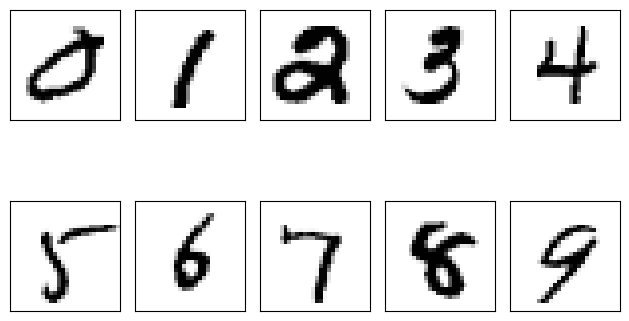

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

TODO: 각 숫자의 샘플을 25개 그려 보세요.

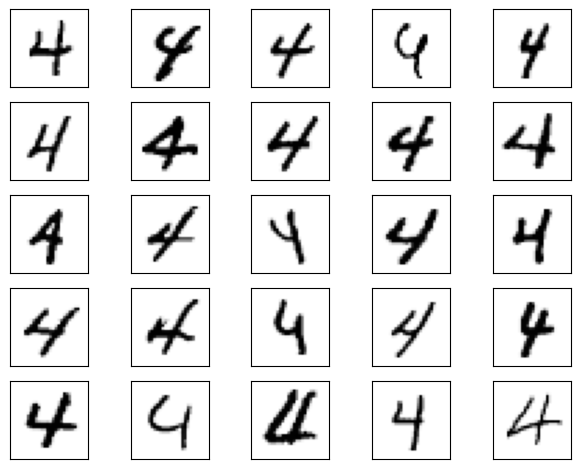

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(25):

    ##################################################
    # TODO: 각 숫자의 샘플을 25개 그려 보세요.

    img = X_train[y_train == 4][i].reshape(28, 28)

    ##################################################

    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Implementing a multi-layer perceptron

In [6]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """피드포워드 신경망 / 다층 퍼셉트론 분류기

    매개변수

    ------------
    n_hidden : int (기본값: 30)
        은닉 유닛 개수
    l2 : float (기본값: 0.)
        L2 규제의 람다 값
        l2=0이면 규제 없음. (기본값)
    epochs : int (기본값: 100)
        훈련 세트를 반복할 횟수
    eta : float (기본값: 0.001)
        학습률
    shuffle : bool (기본값: True)
        에포크마다 훈련 세트를 섞을지 여부
        True이면 데이터를 섞어 순서를 바꿉니다
    minibatch_size : int (기본값: 1)
        미니 배치의 훈련 샘플 개수
    seed : int (기본값: None)
        가중치와 데이터 셔플링을 위한 난수 초깃값

    속성
    -----------
    eval_ : dict
      훈련 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집하기 위한 딕셔너리

    """
    def __init__(self, n_features=784, n_hidden=30, n_output=10,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

        ########################
        # 가중치 초기화
        ########################

        # 입력층 -> 은닉층 사이의 가중치
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # 은닉층 -> 출력층 사이의 가중치
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))
        

    def _onehot(self, y, n_classes):
        """레이블을 원-핫 방식으로 인코딩합니다

        매개변수
        ------------
        y : 배열, 크기 = [n_samples]
            타깃 값.
        n_classes : int
            클래스 개수

        반환값
        -----------
        onehot : 배열, 크기 = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """로지스틱 함수(시그모이드)를 계산합니다"""

        ##################################################
        # TODO: Sigmoid 함수를 구현 해 보세요.

        activation = 1.0 / ( 1.0 + np.exp(-z))

        ##################################################

        return activation

    def _forward(self, X):
        """정방향 계산을 수행합니다"""

        ##################################################
        # TODO: 출력을 계산하는 부분을 완성해 보세요.

        # 단계 1: 은닉층의 최종 입력
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]

        z_h = np.dot(X, self.w_h) + self.b_h

        ##################################################



        # 단계 2: 은닉층의 활성화 출력
        a_h = self._sigmoid(z_h)



        ##################################################
        # TODO: 출력을 계산하는 부분을 완성해 보세요.

        # 단계 3: 출력층의 최종 입력
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]
        z_out = np.dot(a_h, self.w_out) + self.b_out

        ##################################################



        # 단계 4: 출력층의 활성화 출력
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """비용 함수를 계산합니다

        매개변수
        ----------
        y_enc : 배열, 크기 = (n_samples, n_labels)
            원-핫 인코딩된 클래스 레이블
        output : 배열, 크기 = [n_samples, n_output_units]
            출력층의 활성화 출력 (정방향 계산)

        반환값
        ---------
        cost : float
            규제가 포함된 비용

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # 다른 데이터셋에서는 극단적인 (0 또는 1에 가까운) 활성화 값이 나올 수 있습니다.
        # 파이썬과 넘파이의 수치 연산이 불안정하기 때문에 "ZeroDivisionError"가 발생할 수 있습니다.
        # 즉, log(0)을 평가하는 경우입니다.
        # 이 문제를 해결하기 위해 로그 함수에 전달되는 활성화 값에 작은 상수를 더합니다.
        #
        # 예를 들어:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """클래스 레이블을 예측합니다

        매개변수
        -----------
        X : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층

        반환값:
        ----------
        y_pred : 배열, 크기 = [n_samples]
            예측된 클래스 레이블

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """훈련 데이터에서 가중치를 학습합니다

        매개변수
        -----------
        X_train : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층
        y_train : 배열, 크기 = [n_samples]
            타깃 클래스 레이블
        X_valid : 배열, 크기 = [n_samples, n_features]
            훈련하는 동안 검증에 사용할 샘플 특성
        y_valid : 배열, 크기 = [n_samples]
            훈련하는 동안 검증에 사용할 샘플 레이블

        반환값:
        ----------
        self

        """
        n_features = X_train.shape[1]
        n_output = np.unique(y_train).shape[0]  # number of class labels

        assert self.n_features == n_features
        assert self.n_output == n_output

        epoch_strlen = len(str(self.epochs))  # 출력 포맷을 위해
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # 훈련 에포크를 반복합니다
        for i in range(self.epochs):

            # 미니 배치로 반복합니다
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # 정방향 계산
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # 역전파
                ##################

                # [n_examples, n_classlabels]
                delta_out = a_out - y_train_enc[batch_idx]

                # [n_examples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_examples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_examples, n_hidden]
                delta_h = (np.dot(delta_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_examples] dot [n_examples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, delta_h)
                grad_b_h = np.sum(delta_h, axis=0)

                # [n_hidden, n_examples] dot [n_examples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, delta_out)
                grad_b_out = np.sum(delta_out, axis=0)

                # 규제와 가중치 업데이트
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # 편향은 규제하지 않습니다
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # 편향은 규제하지 않습니다
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # 평가
            #############

            # 훈련하는 동안 에포크마다 평가합니다
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | 비용: %.2f '
                             '| 훈련/검증 정확도: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [7]:
n_epochs = 20

In [44]:
nn = NeuralNetMLP(n_hidden=100, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.0005,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=1)

nn.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

20/20 | 비용: 19027.33 | 훈련/검증 정확도: 95.11%/94.30% 

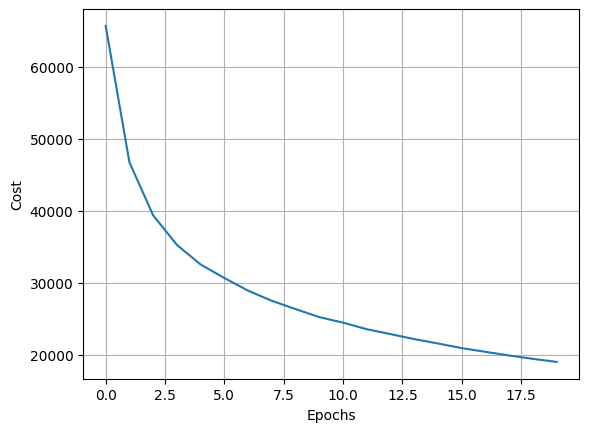

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.grid()
plt.show()

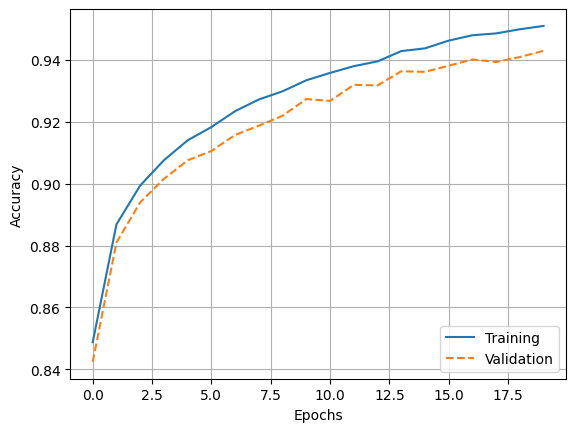

In [46]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], 
         label='Training')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], 
         label='Validation', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [47]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test == y_test_pred)
       .astype(float) / X_test.shape[0])

print('테스트 정확도: %.2f%%' % (acc * 100))

테스트 정확도: 94.48%


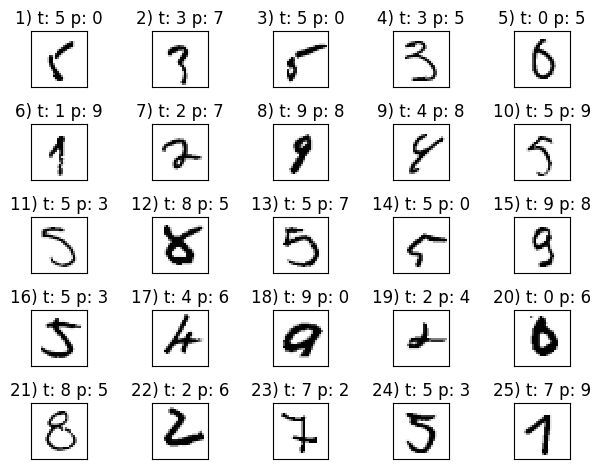

In [48]:
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i+1, correct_lab[i], miscl_lab[i]))

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [49]:
# Challenge: Neural Network의 Parameter들을 바꾸어 가며 성능 향상을 달성 해 보세요.

nn2 = NeuralNetMLP(n_hidden=128, 
                  l2=0.01, 
                  epochs=n_epochs, 
                  eta=0.002,
                  minibatch_size=100, 
                  shuffle=True,
                  seed=24590)

nn2.fit(X_train=X_train[:55000], 
       y_train=y_train[:55000],
       X_valid=X_train[55000:],
       y_valid=y_train[55000:])

20/20 | 비용: 8137.09 | 훈련/검증 정확도: 98.31%/96.94% 

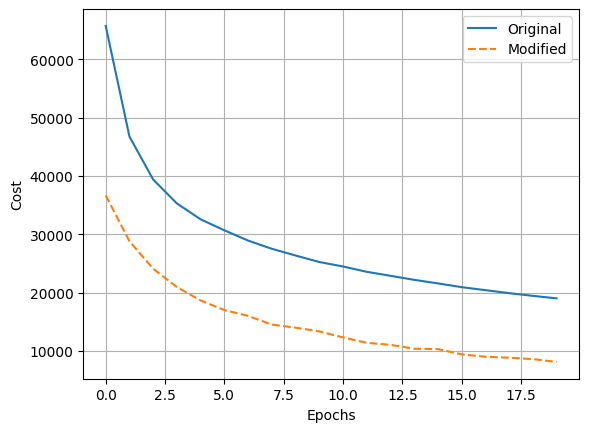

In [50]:
import matplotlib.pyplot as plt

plt.plot(range(nn.epochs), nn.eval_['cost'], label='Original')
plt.plot(range(nn2.epochs), nn2.eval_['cost'], label='Modified', linestyle='--')
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.legend(loc='upper right')
plt.grid()
plt.show()

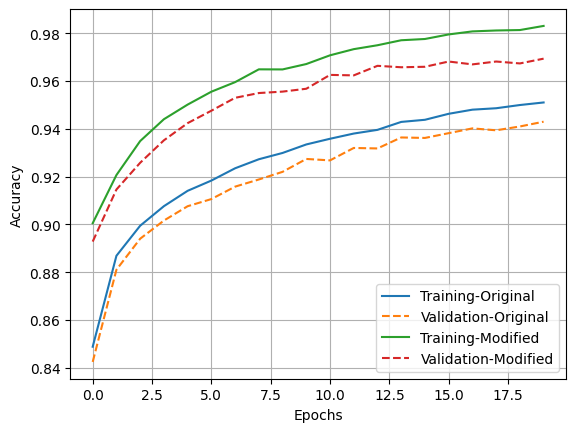

In [51]:
plt.plot(range(nn.epochs), nn.eval_['train_acc'], label='Training-Original')
plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label='Validation-Original', linestyle='--')
plt.plot(range(nn2.epochs), nn2.eval_['train_acc'], label='Training-Modified')
plt.plot(range(nn2.epochs), nn2.eval_['valid_acc'], label='Validation-Modified', linestyle='--')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [52]:
y_test_pred2 = nn2.predict(X_test)
acc = (np.sum(y_test == y_test_pred2)
       .astype(float) / X_test.shape[0])

print('테스트 정확도: %.2f%%' % (acc * 100))

테스트 정확도: 97.02%
